# Skin Cancer Melanoma Detection using custom CNN Model

## Problem statement: 

To build a CNN based model which can accurately detect `melanoma`. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Dataset Description


The dataset consists of `2357 images of malignant and benign oncological` diseases, which were formed from the **International Skin Imaging Collaboration (ISIC)**. All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.
The data set contains the following diseases:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important Libraries

In [1]:
# Importing necessary libraries for Convolution Nural Network Model building and visualization

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import PIL
import glob
import cv2
from tensorflow.keras.layers import Dense, Conv2D, Activation, Dropout, BatchNormalization, MaxPooling2D, AveragePooling2D, Flatten
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Setting max display options
pd.set_option('display.max_colwidth', 2000)

# Importing library for ignoring warnning in the executed code
import warnings
warnings.filterwarnings("ignore")

# setting the backend of matplotlib to the 'inline' backend
%matplotlib inline

## Checking GPU utilization Details

In [2]:
# Checking whether GPU device is allocated or not for this session

if tf.test.gpu_device_name():
     print((tf.test.gpu_device_name()))
else:
     print('install')

/device:GPU:0


In [3]:
# Forcefully allocating 100% GPU memory to the current session

gpu_opts=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=1)
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_opts))

In [4]:
# Checking whether GPU and cuda are interacting with tensorflow

print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [41]:
# Command for checking current Grapics card details and cuda versions 

! nvidia-smi

Sun Apr 11 14:49:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    27W /  70W |   4930MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Google Drive mounting with Google Colab

In [5]:
# Used below code to mount Google drive to Google Colab
# Also, commented out below code as mounting completed

## If you are using the data by mounting the google drive, use the following :
#from google.colab import drive
#drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [6]:
# Below code used for unzipping the CNN Image Dataset folder as it was uploaded in google drive as zipped file
# Commented below code after completing unzipping

#!unzip /content/gdrive/MyDrive/CNN_Projects/CNN_assignment.zip

Archive:  /content/gdrive/MyDrive/CNN_Projects/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg 

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Note:

- After mounting with Google Drive we have unzipped the assignment dataset for further processing
- The code for mounting and unzipping has been commented out once drive was mounted with colab and dataset was unzipped
- If required, you can uncomment and run it replacing the necessary path

## Data Reading

- Defining the Google Drive path for train and test images
- Counting the number of images in each folders (Train & Test)

In [7]:
# Defining the Google Drive path for train and test images

# Train Dataset: /content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train
# Test Dataset: /content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Test

data_dir_train = pathlib.Path('/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [8]:
# Displaying image counts from Train and Test folders 

# Number of images present in Train Folder
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

# Number of images present in Test Folder
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Inference:

- We can see that, the `Training` folder is containing **2239** images, while is `Test` folder is containing **118** images

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [9]:
# Defining batch_size parameter for model training along with image height and width. These variables will be referred further duting training

batch_size = 32
img_height = 180
img_width = 180

## Spliting Training dataset into Training & Validation dataset

Use 80% of the images for training, and 20% for validation.

In [10]:
## Write your train dataset here

# Creating Training Dataset using tf.keras.preprocessing.image_dataset_from_directory method with 80% images from Train Folder using seed=123, img_height=180, img_width=180 and batch_size=32

## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


- **80%** of images from Training Folder has been used to create **Training** dataset

In [11]:
## Write your validation dataset here

# Creating Validation Dataset using tf.keras.preprocessing.image_dataset_from_directory method with 20% images from Train Folder using seed=123, img_height=180, img_width=180 and batch_size=32

## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


- **20%** of images from Training Folder has been used to create **Testing** dataset

### Listing out all the classes of skin cancer 

In [12]:
# Displaying number of distinct classes of skin cancer along with the name of each class

# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
print("")

num_classes = len(class_names)
print("Number of Classes in Dataset:", num_classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

Number of Classes in Dataset: 9


### Inference:

- We can see that there are total 9 distinct classes present in Training data.
- The classes are: `actinic keratosis`, `basal cell carcinoma`, `dermatofibroma`, `melanoma`, `nevus`, `pigmented benign keratosis`, `seborrheic keratosis`, `squamous cell carcinoma`, `vascular lesion`

## Dataset visualisation 

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

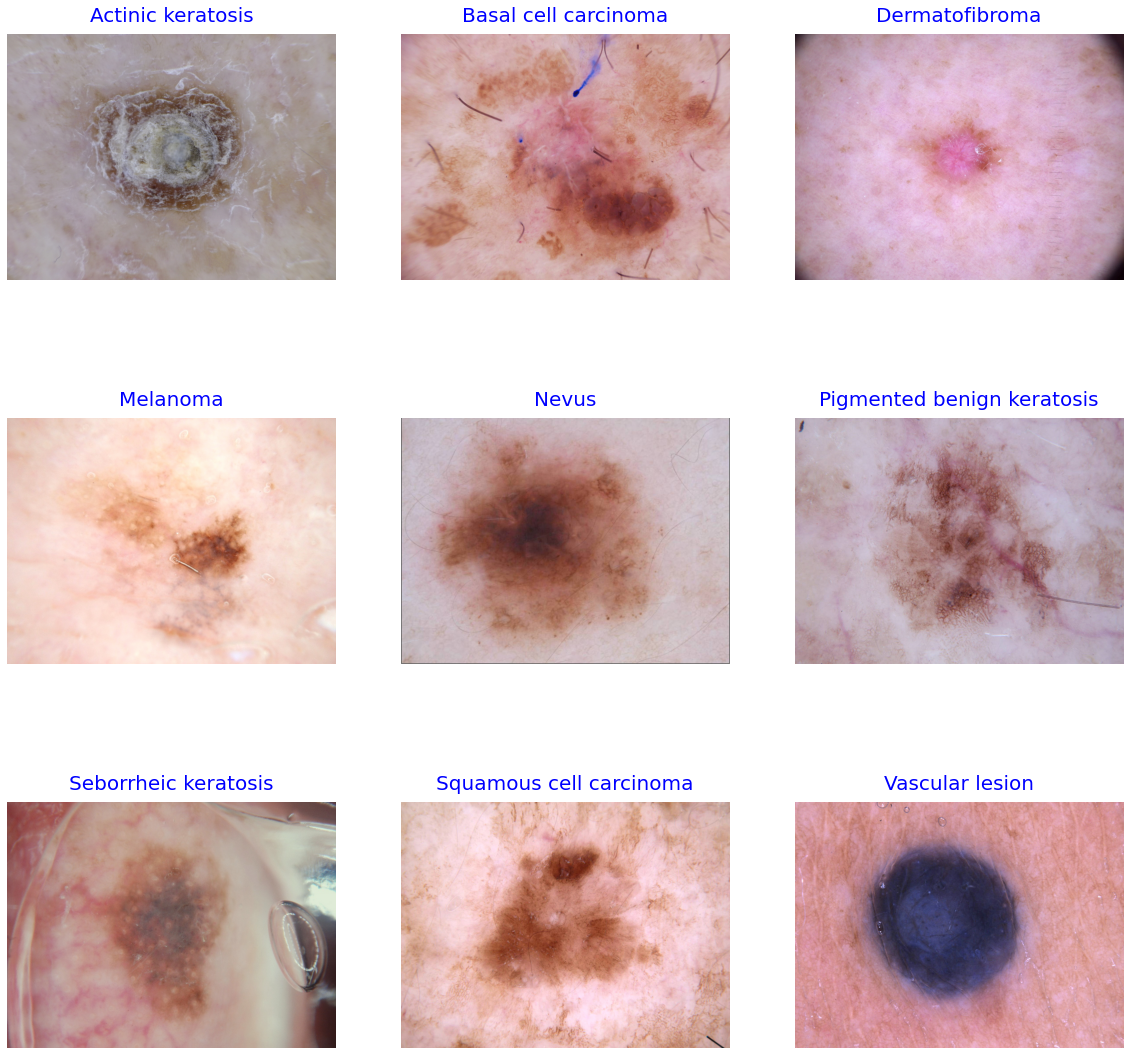

In [ ]:
# Importing matplotlib.pyplot library for image visualization
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
print("")

# Setting the figure size for visualization
plt.figure(figsize=(20, 20))

# Loop through each skin cancer class names
for index,class_name in enumerate(class_names):

    # Joining the Training directory path along with class name to create path for each class directory
    path = os.path.join(data_dir_train, class_name)

    # Setting co-ordinates for sub-plots
    plt.subplot(3,3,index+1)

    # Loop through each images from each class directory
    for image in os.listdir(path):

        # Converting each imahe into an array
        image_array = cv2.imread(os.path.join(path,image))

        # Formatting the image color to display in RGB code
        img = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)

        # Displaying the image of each class instance
        plt.imshow(img)

        # Setting the title for each class of image
        plt.title(class_name.capitalize(), fontsize = 20, color = 'blue', pad = 12)

        # Supressing the axis labels
        plt.axis("off")

        # Use break to display only one image from each class
        break

# Using matplotlib.pyplot show() function to plot the images        
plt.show()

### Inference:

- From above visualization, we can see the difference in pattern among each `9 classes` of skin cancer types.
- We will be developing a model which can able to classify the images of each type, when we feed any image to the convolution nural network

### Visualize first 9 random images from Training Dataset

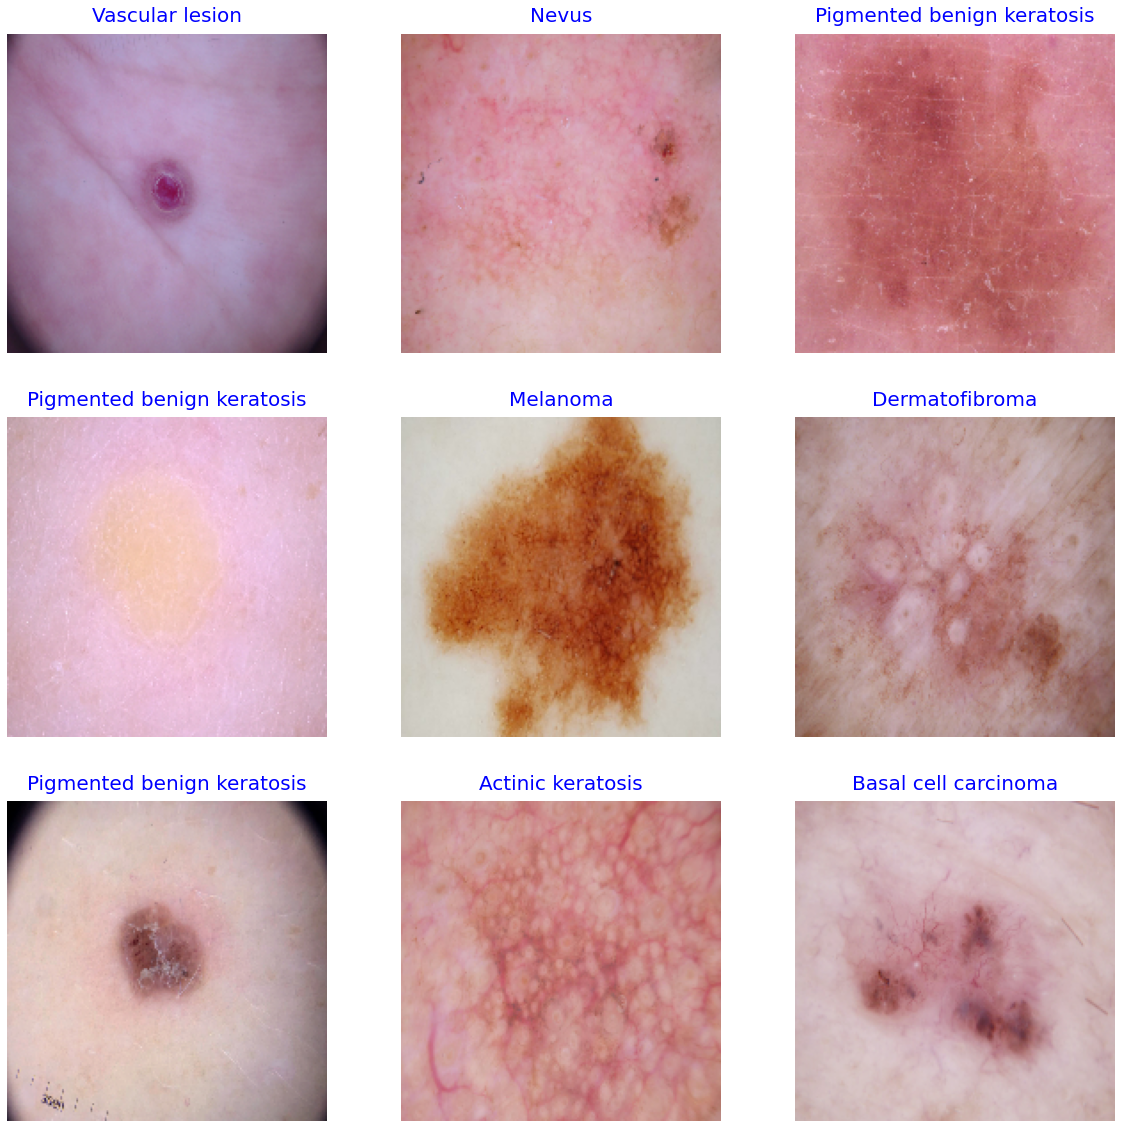

In [ ]:
# Visualize the first 9 images from the training dataset

# Setting the figure size
plt.figure(figsize=(20, 20))

# Loop through the one instance of training dataset with image shape (32, 180, 180, 3) and label shape (32,)
for images, labels in train_ds.take(1):

    # Loop to display 9 image
    for idx in range(9):

        # Setting sub-plot coordinates
        ax = plt.subplot(3, 3, idx + 1)

        # Showing the image after converting into integer
        plt.imshow(images[idx].numpy().astype("uint8"))

        # Setting title of each image with class name
        plt.title(class_names[labels[idx]].capitalize(), fontsize = 20, color = 'blue', pad = 12)

        # Supressing the axis labels
        plt.axis("off")

### Inference:

- Above are the randomly picked 9 images from the Training dataset, which will be used to train our custom CNN model

## Performence Improvement Technique

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
# Use autotune feature and create dataset cache to keep images in memory after they're loaded off disk during the first epoch
# Also use prefetch() to overlap data preprocessing and model execution while training

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Building & Training

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

### Creating CNN Model 1

In [ ]:
### Your code goes here

# Use Sequential from tensorflow.models library to build CNN model layer by layer
# Below model used following layers:
## First layer is used to rescalling the input of nural network from range [0, 255] to [0, 1]
## Two convolution layers with filter size (3,3) and number of filters used 64 and padding as "same" (i.e. after convolution the output layer size will be same as input layer)
## Two max pooling layer with filter size (2,2)
## One Flatten layer
## Two fully connected layer (including output softmax layer)
## Convolution and Fully connected layers used activation function 'relu'

cnn_model = Sequential()
cnn_model.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale = (1.0 / 255), input_shape=(img_height, img_width,3)))
cnn_model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (2,2)))

cnn_model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (2,2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(num_classes, activation='softmax'))


- We have done `rescaling` before feeding the input into the Convolution Nural Network

### Compile the model 1
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Todo, choose an appropirate optimiser and loss function

# Compile the cnn model with 'Adam' optimizer and 'sparse_categorical_crossentropy' loss function
# Used 'Accuracy' as eveluation metric

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

- The first CNN model uses **Adam** as optimizer and **sparse_categorical_crossentropy** as loss function
- We have used **Accuracy** metric for model evaluation

### Viewing Summary of Model 1

In [ ]:
# View the summary of all layers
cnn_model.summary()

Model: "sequential_118"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_52 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_384 (Conv2D)          (None, 180, 180, 64)      1792      
_________________________________________________________________
max_pooling2d_197 (MaxPoolin (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_385 (Conv2D)          (None, 90, 90, 64)        36928     
_________________________________________________________________
max_pooling2d_198 (MaxPoolin (None, 45, 45, 64)        0         
_________________________________________________________________
flatten_85 (Flatten)         (None, 129600)            0         
_________________________________________________________________
dense_231 (Dense)            (None, 128)            

### Train the model 1

In [ ]:
# Fiting the model

# Train the model with 20 epochs

epochs = 20
history = cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 19s 105ms/step - loss: 2.9270 - accuracy: 0.2048 - val_loss: 1.7201 - val_accuracy: 0.3468
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 1.6890 - accuracy: 0.3939 - val_loss: 1.4738 - val_accuracy: 0.5078
Epoch 3/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4876 - accuracy: 0.4968 - val_loss: 1.5008 - val_accuracy: 0.5280
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4150 - accuracy: 0.5202 - val_loss: 1.3790 - val_accuracy: 0.5414
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3268 - accuracy: 0.5462 - val_loss: 1.3879 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 2s 41ms/step - loss: 1.1227 - accuracy: 0.6076 - val_loss: 1.4356 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.1073 - accuracy: 0.5988 - val_loss: 1.4844 - val_accuracy: 0.5101
Epoch 8/20


### Visualizing training results of CNN Model 1

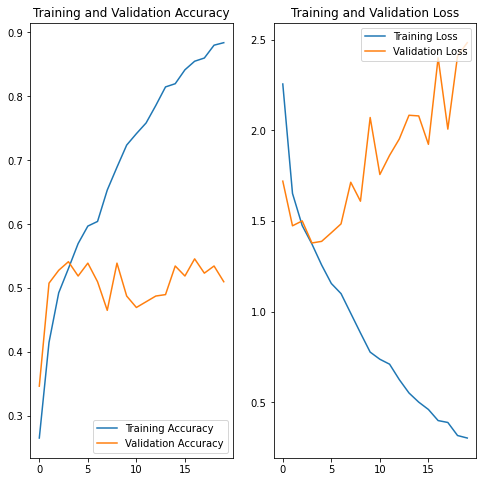

In [ ]:
# Visualizing the Training and Validation accuracy and loss against the epochs


# Getting the traning accuracy from history object created during model fitting
acc = history.history['accuracy']

# Getting the validation accuracy from history object created during model fitting
val_acc = history.history['val_accuracy']

# Getting the training loss from history object created during model fitting
loss = history.history['loss']

# Getting the validation loss from history object created during model fitting
val_loss = history.history['val_loss']

# Creating a list variable with number of epochs
epochs_range = range(epochs)

# Setting figute size for the plot
plt.figure(figsize=(8, 8))


# Setting subplot coordinate
plt.subplot(1, 2, 1)

# Plotting epoch vs. training accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')

# Plotting epoch vs. validation accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

# Setting display options
plt.legend(loc='lower right')

# Setting plot title
plt.title('Training and Validation Accuracy')


# Setting subplot coordinate
plt.subplot(1, 2, 2)

# Plotting epoch vs. training loss
plt.plot(epochs_range, loss, label='Training Loss')

# Plotting epoch vs. validation accuracy
plt.plot(epochs_range, val_loss, label='Validation Loss')

# Setting display options
plt.legend(loc='upper right')

# Setting plot title
plt.title('Training and Validation Loss')

# Showing the plot with show() method of matplotlib.pyplot 
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Inference:

- We can see from the aobve graphs , that the model is very much **`overfitted`** ,with the train accuracy of `0.8925` (89%) and validation accuracy of `0.5101`(51%)


- We can see from the aobve graphs , that the model has stop learning in terms of loss optimization, with the train loss of `0.2793` and validation loss of `2.4837`. After a certain point in validation set, model has stop learning, hence loss increases.

### Creating CNN Model 2

- Increasing Convolution Layers and using Droupout

In [ ]:
### Your code goes here

# Use Sequential from tensorflow.models library to build CNN model layer by layer
# Below model used following layers:
## First layer is used to rescalling the input of nural network from range [0, 255] to [0, 1]
## Four convolution layers with filter size (3,3) and number of filters used 32 and 64 respectively and two layers used padding as "same" (i.e. after convolution the output layer size will be same as input layer)
## Two max pooling layer with filter size (2,2)
## One Flatten layer
## Two fully connected layer (including output softmax layer)
## Convolution and Fully connected layers used activation function 'relu'
## Used Dropout(0.25) after two convotution layer and Dropout(0.5) in FC layer

cnn_model = Sequential()
cnn_model.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale = (1.0 / 255), input_shape=(img_height, img_width,3)))
cnn_model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cnn_model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (2,2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cnn_model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (2,2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='softmax'))


### Compile the CNN model 2

In [ ]:
### Todo, choose an appropirate optimiser and loss function

# Compile the cnn model with 'Adam' optimizer and 'sparse_categorical_crossentropy' loss function
# Used 'Accuracy' as eveluation metric

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

- This CNN model uses **Adam** as optimizer and **sparse_categorical_crossentropy** as loss function
- We have used **Accuracy** metric for model evaluation

### Viewing the summary of CNN Model 2

In [ ]:
# View the summary of all layers
cnn_model.summary()

Model: "sequential_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_53 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_386 (Conv2D)          (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_387 (Conv2D)          (None, 178, 178, 32)      9248      
_________________________________________________________________
max_pooling2d_199 (MaxPoolin (None, 89, 89, 32)        0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_388 (Conv2D)          (None, 89, 89, 64)        18496     
_________________________________________________________________
conv2d_389 (Conv2D)          (None, 87, 87, 64)     

### Train the Model 2

In [ ]:
# Fiting the model

# Train the model with 20 epochs

epochs = 20
history = cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 80ms/step - loss: 4.8440 - accuracy: 0.1882 - val_loss: 2.0299 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 4s 78ms/step - loss: 2.0334 - accuracy: 0.2087 - val_loss: 2.0220 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 4s 78ms/step - loss: 1.9401 - accuracy: 0.2575 - val_loss: 1.7778 - val_accuracy: 0.4116
Epoch 4/20
56/56 [==============================] - 4s 78ms/step - loss: 1.8491 - accuracy: 0.3238 - val_loss: 1.6414 - val_accuracy: 0.4474
Epoch 5/20
56/56 [==============================] - 4s 78ms/step - loss: 1.7521 - accuracy: 0.3529 - val_loss: 1.4959 - val_accuracy: 0.4810
Epoch 6/20
56/56 [==============================] - 4s 78ms/step - loss: 1.4974 - accuracy: 0.4843 - val_loss: 1.4534 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 4s 78ms/step - loss: 1.4526 - accuracy: 0.5064 - val_loss: 1.5163 - val_accuracy: 0.4810
Epoch 8/20
56

### Visualizing training results of CNN model 2

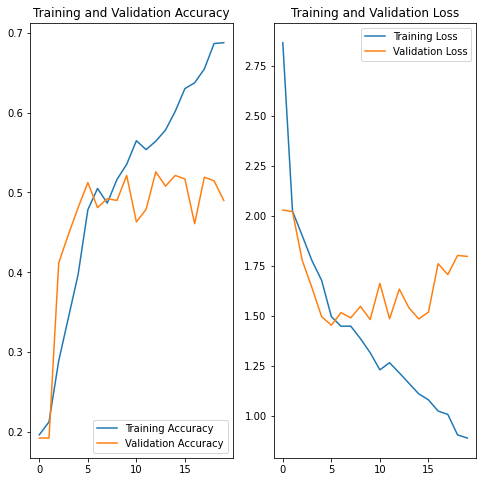

In [ ]:
# Visualizing the Training and Validation accuracy and loss against the epochs


# Getting the traning accuracy from history object created during model fitting
acc = history.history['accuracy']

# Getting the validation accuracy from history object created during model fitting
val_acc = history.history['val_accuracy']

# Getting the training loss from history object created during model fitting
loss = history.history['loss']

# Getting the validation loss from history object created during model fitting
val_loss = history.history['val_loss']

# Creating a list variable with number of epochs
epochs_range = range(epochs)

# Setting figute size for the plot
plt.figure(figsize=(8, 8))


# Setting subplot coordinate
plt.subplot(1, 2, 1)

# Plotting epoch vs. training accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')

# Plotting epoch vs. validation accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

# Setting display options
plt.legend(loc='lower right')

# Setting plot title
plt.title('Training and Validation Accuracy')


# Setting subplot coordinate
plt.subplot(1, 2, 2)

# Plotting epoch vs. training loss
plt.plot(epochs_range, loss, label='Training Loss')

# Plotting epoch vs. validation accuracy
plt.plot(epochs_range, val_loss, label='Validation Loss')

# Setting display options
plt.legend(loc='upper right')

# Setting plot title
plt.title('Training and Validation Loss')

# Showing the plot with show() method of matplotlib.pyplot 
plt.show()

### Inference:

- After introduction of `droput layers` as well we can see from the aobve graphs , that the model is still very much **`overfitted`** ,with the train accuracy of `0.6851` (68.51%) and validation accuracy of `0.4899`(48.99%)


- We can see from the aobve graphs , that the model has stop learning in terms of loss optimization,with the train loss of `0.8750` and validation loss of `1.7979`. After a certain point in validation set, model has stop learning, hence loss increases.

### Create CNN Model 3

- Perform BatchNormalization at each batch input and adding droupout layer

In [ ]:
### Your code goes here

# Use Sequential from tensorflow.models library to build CNN model layer by layer
# Below model used following layers:
## First layer is used to rescalling the input of nural network from range [0, 255] to [0, 1]
## Four convolution layers with filter size (3,3) and number of filters used 64 and padding as "same" (i.e. after convolution the output layer size will be same as input layer)
## Two max pooling layer with filter size (2,2)
## One Flatten layer
## Two fully connected layer (including output softmax layer) with 512 number of filters
## Convolution and Fully connected layers used activation function 'relu'
## Used Dropout(0.25) after two convotution layer and Dropout(0.5) in FC layer
## Used BatchNormalization in each convolution layer

cnn_model = Sequential()
cnn_model.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale = (1.0 / 255), input_shape=(img_height, img_width,3)))
cnn_model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size = (2,2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size = (2,2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='softmax'))

### Compile CNN Model 3

In [ ]:
### Todo, choose an appropirate optimiser and loss function

# Compile the cnn model with 'Adam' optimizer and 'sparse_categorical_crossentropy' loss function
# Used 'Accuracy' as eveluation metric


cnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


- This CNN model uses **Adam** as optimizer and **sparse_categorical_crossentropy** as loss function
- We have used **Accuracy** metric for model evaluation

### Viewing the Summary of Model 3

In [ ]:
# View the summary of all layers
cnn_model.summary()

Model: "sequential_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_54 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_390 (Conv2D)          (None, 180, 180, 32)      896       
_________________________________________________________________
batch_normalization_54 (Batc (None, 180, 180, 32)      128       
_________________________________________________________________
conv2d_391 (Conv2D)          (None, 178, 178, 32)      9248      
_________________________________________________________________
batch_normalization_55 (Batc (None, 178, 178, 32)      128       
_________________________________________________________________
max_pooling2d_201 (MaxPoolin (None, 89, 89, 32)        0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 89, 89, 32)     

### Train the Model 3

In [ ]:
# Fiting the model

# Train the model with 20 epochs

epochs = 20
history = cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 101ms/step - loss: 63.0176 - accuracy: 0.3090 - val_loss: 29.6600 - val_accuracy: 0.0559
Epoch 2/20
56/56 [==============================] - 5s 98ms/step - loss: 10.6382 - accuracy: 0.3126 - val_loss: 162.4829 - val_accuracy: 0.0403
Epoch 3/20
56/56 [==============================] - 5s 97ms/step - loss: 2.3305 - accuracy: 0.2381 - val_loss: 137.1795 - val_accuracy: 0.0403
Epoch 4/20
56/56 [==============================] - 5s 97ms/step - loss: 2.0652 - accuracy: 0.2735 - val_loss: 98.3662 - val_accuracy: 0.0403
Epoch 5/20
56/56 [==============================] - 5s 97ms/step - loss: 1.9479 - accuracy: 0.3135 - val_loss: 119.4004 - val_accuracy: 0.0403
Epoch 6/20
56/56 [==============================] - 5s 98ms/step - loss: 1.9131 - accuracy: 0.3226 - val_loss: 93.2001 - val_accuracy: 0.0492
Epoch 7/20
56/56 [==============================] - 5s 98ms/step - loss: 1.8568 - accuracy: 0.3317 - val_loss: 54.7790 - val_accuracy: 0.0940


### Visualizing training results of CNN model 3

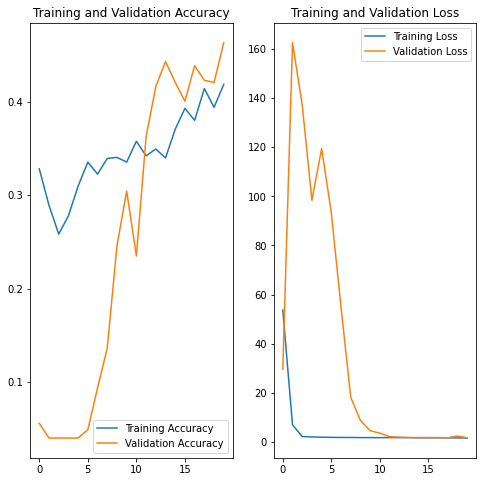

In [ ]:
# Visualizing the Training and Validation accuracy and loss against the epochs


# Getting the traning accuracy from history object created during model fitting
acc = history.history['accuracy']

# Getting the validation accuracy from history object created during model fitting
val_acc = history.history['val_accuracy']

# Getting the training loss from history object created during model fitting
loss = history.history['loss']

# Getting the validation loss from history object created during model fitting
val_loss = history.history['val_loss']

# Creating a list variable with number of epochs
epochs_range = range(epochs)

# Setting figute size for the plot
plt.figure(figsize=(8, 8))


# Setting subplot coordinate
plt.subplot(1, 2, 1)

# Plotting epoch vs. training accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')

# Plotting epoch vs. validation accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

# Setting display options
plt.legend(loc='lower right')

# Setting plot title
plt.title('Training and Validation Accuracy')


# Setting subplot coordinate
plt.subplot(1, 2, 2)

# Plotting epoch vs. training loss
plt.plot(epochs_range, loss, label='Training Loss')

# Plotting epoch vs. validation accuracy
plt.plot(epochs_range, val_loss, label='Validation Loss')

# Setting display options
plt.legend(loc='upper right')

# Setting plot title
plt.title('Training and Validation Loss')

# Showing the plot with show() method of matplotlib.pyplot 
plt.show()

### Inference:


- After introduction of `dropout layer and batch normlization` also used `Adam optimizer` we can see from the aobve graphs , that the model is reduced its **`Overfitted`** behaviour, and somewhat **`Underfitted`** ,with the train accuracy of `0.4205` (42.05%) and validation accuracy of `0.4631`(46.31%).


- But the model accuracy is decreased very much in train as well as validation set.


- We can see from the aobve graphs , that the model has stop learning in terms of loss optimization,with the train loss of `1.6122` and validation loss of `1.7401`. After a certain point in validation set, model has stop learning, hence loss increases.

### Create CNN Model 4

- Changing optimizer to `rmsprop`

In [ ]:
### Your code goes here

# Use Sequential from tensorflow.models library to build CNN model layer by layer
# Below model used following layers:
## First layer is used to rescalling the input of nural network from range [0, 255] to [0, 1]
## Four convolution layers with filter size (3,3) and number of filters used 64 and padding as "same" (i.e. after convolution the output layer size will be same as input layer)
## Two max pooling layer with filter size (2,2)
## One Flatten layer
## Two fully connected layer (including output softmax layer) with 512 number of filters
## Convolution and Fully connected layers used activation function 'relu'
## Used Dropout(0.25) after two convotution layer and Dropout(0.5) in FC layer
## Used BatchNormalization in each convolution layer

cnn_model = Sequential()
cnn_model.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale = (1.0 / 255), input_shape=(img_height, img_width,3)))
cnn_model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size = (2,2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size = (2,2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='softmax'))

### Compile CNN Model 4

In [ ]:
### Todo, choose an appropirate optimiser and loss function

# Compile the cnn model with 'rmsprop' optimizer and 'sparse_categorical_crossentropy' loss function
# Used 'Accuracy' as eveluation metric

cnn_model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


- This CNN model uses **rmsprop** as optimizer and **sparse_categorical_crossentropy** as loss function
- We have used **Accuracy** metric for model evaluation

### Viewing the Summary of CNN Model 4

In [ ]:
# View the summary of all layers
cnn_model.summary()

Model: "sequential_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_55 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_394 (Conv2D)          (None, 180, 180, 32)      896       
_________________________________________________________________
batch_normalization_58 (Batc (None, 180, 180, 32)      128       
_________________________________________________________________
conv2d_395 (Conv2D)          (None, 178, 178, 32)      9248      
_________________________________________________________________
batch_normalization_59 (Batc (None, 178, 178, 32)      128       
_________________________________________________________________
max_pooling2d_203 (MaxPoolin (None, 89, 89, 32)        0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 89, 89, 32)     

### Training CNN Model 4

In [ ]:
# Fiting the model

# Train the model with 20 epochs

epochs = 20
history = cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 114ms/step - loss: 94.2776 - accuracy: 0.2655 - val_loss: 28.9730 - val_accuracy: 0.0537
Epoch 2/20
56/56 [==============================] - 6s 110ms/step - loss: 2.6421 - accuracy: 0.2190 - val_loss: 13.9950 - val_accuracy: 0.0716
Epoch 3/20
56/56 [==============================] - 6s 110ms/step - loss: 2.6892 - accuracy: 0.2366 - val_loss: 25.8732 - val_accuracy: 0.0872
Epoch 4/20
56/56 [==============================] - 6s 110ms/step - loss: 2.2676 - accuracy: 0.3047 - val_loss: 27.0337 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 6s 110ms/step - loss: 2.2519 - accuracy: 0.2748 - val_loss: 5.2497 - val_accuracy: 0.1029
Epoch 6/20
56/56 [==============================] - 6s 109ms/step - loss: 2.0250 - accuracy: 0.2924 - val_loss: 9.4282 - val_accuracy: 0.1521
Epoch 7/20
56/56 [==============================] - 6s 110ms/step - loss: 2.0235 - accuracy: 0.2711 - val_loss: 2.3534 - val_accuracy: 0.1700
E

### Visualizing training results of CNN Model 4

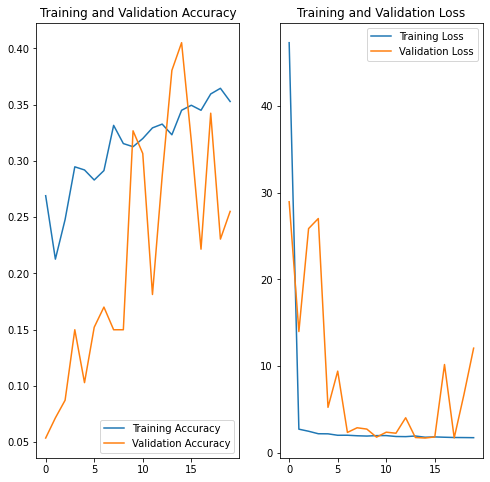

In [ ]:
# Visualizing the Training and Validation accuracy and loss against the epochs


# Getting the traning accuracy from history object created during model fitting
acc = history.history['accuracy']

# Getting the validation accuracy from history object created during model fitting
val_acc = history.history['val_accuracy']

# Getting the training loss from history object created during model fitting
loss = history.history['loss']

# Getting the validation loss from history object created during model fitting
val_loss = history.history['val_loss']

# Creating a list variable with number of epochs
epochs_range = range(epochs)

# Setting figute size for the plot
plt.figure(figsize=(8, 8))


# Setting subplot coordinate
plt.subplot(1, 2, 1)

# Plotting epoch vs. training accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')

# Plotting epoch vs. validation accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

# Setting display options
plt.legend(loc='lower right')

# Setting plot title
plt.title('Training and Validation Accuracy')


# Setting subplot coordinate
plt.subplot(1, 2, 2)

# Plotting epoch vs. training loss
plt.plot(epochs_range, loss, label='Training Loss')

# Plotting epoch vs. validation accuracy
plt.plot(epochs_range, val_loss, label='Validation Loss')

# Setting display options
plt.legend(loc='upper right')

# Setting plot title
plt.title('Training and Validation Loss')

# Showing the plot with show() method of matplotlib.pyplot 
plt.show()

### Inference:

- After introduction of `dropout layer and batch normlization` also used `rmsprop optimizer` as well we can see from the aobve graphs , that the model is very much **`Underfitted`** ,with the train accuracy of `0.3584` (35.84%) and validation accuracy of `0.2550`(25.50%)


- We can see from the aobve graphs ,that the model has stop learning in terms of loss optimization, with the train loss of `1.7514` and validation loss of `12.0782`. After a certain point in validation set, model has stop learning, hence loss increases.

## Overall Summary on the above build models


- From the above model training activities (4 CNN model trained) it has been evident that the majority of the models are **`Overfitted`** 


**` CNN Model 1 `**:

- We can see from the visualization , that the model is very much **`overfitted`** ,with the train accuracy of `0.8925` (89%) and validation accuracy of `0.5101`(51%)


- Also we saw, that the model has stop learning in terms of loss optimization, with the train loss of `0.2793` and validation loss of `2.4837`. After a certain point in validation set, model has stop learning, hence loss increases.


**` CNN Model 2 `**:

- After introduction of `droput layers` as well we can see from the aobve graphs , that the model is still very much **`overfitted`** ,with the train accuracy of `0.6851` (68.51%) and validation accuracy of `0.4899`(48.99%)


- We can see from visualization, that the model has stop learning in terms of loss optimization,with the train loss of `0.8750` and validation loss of `1.7979`. After a certain point in validation set, model has stop learning, hence loss increases.


**` CNN Model 3 `**:


- After introduction of `dropout layer and batch normlization` also used `Adam optimizer` we can see from the aobve graphs , that the model is reduced its **`Overfitted`** behaviour, and somewhat **`Underfitted`** ,with the train accuracy of `0.4205` (42.05%) and validation accuracy of `0.4631`(46.31%).


- We also observed that the model accuracy is decreased very much in train as well as validation set.


- We can see from visualization, that the model has stop learning in terms of loss optimization,with the train loss of `1.6122` and validation loss of `1.7401`. After a certain point in validation set, model has stop learning, hence loss increases.



**` CNN Model 4 `**:


- After introduction of `dropout layer and batch normlization` also used `rmsprop optimizer` as well we can see from the aobve graphs , that the model is very much **`Underfitted`** ,with the train accuracy of `0.3584` (35.84%) and validation accuracy of `0.2550`(25.50%)


- We can visualize, that the model has stop learning in terms of loss optimization, with the train loss of `1.7514` and validation loss of `12.0782`. After a certain point in validation set, model has stop learning, hence loss increases.


## Data Augmentation strategy performed

### Model 1 with Augmentation

- `Rescaling` to reduce data range from [0, 255] to [0, 1]
- `RandomFlip` with horizontal_and_vertical mode and seed as 123
- `RandomRotation` with factor 0.2 and seed value as 123
- `RandomZoom` with factor 0.2 and seed value as 123

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

# Applying following data augmentation strategy to reduce overfitting present in above model
## Rescaling to reduce data range from [0, 255] to [0, 1]
## RandomFlip with horizontal_and_vertical mode and seed as 123
## RandomRotation with factor 0.2 and seed value as 123
## RandomZoom with factor 0.2 and seed value as 123

ImageData_augmentation = Sequential()
ImageData_augmentation.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale = (1.0 / 255),input_shape = (img_height, img_width,3)))
ImageData_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical', seed=123))
ImageData_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.2, seed=123))
ImageData_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, seed=123))


### Visualizing augmentation strategy for one instance of training image

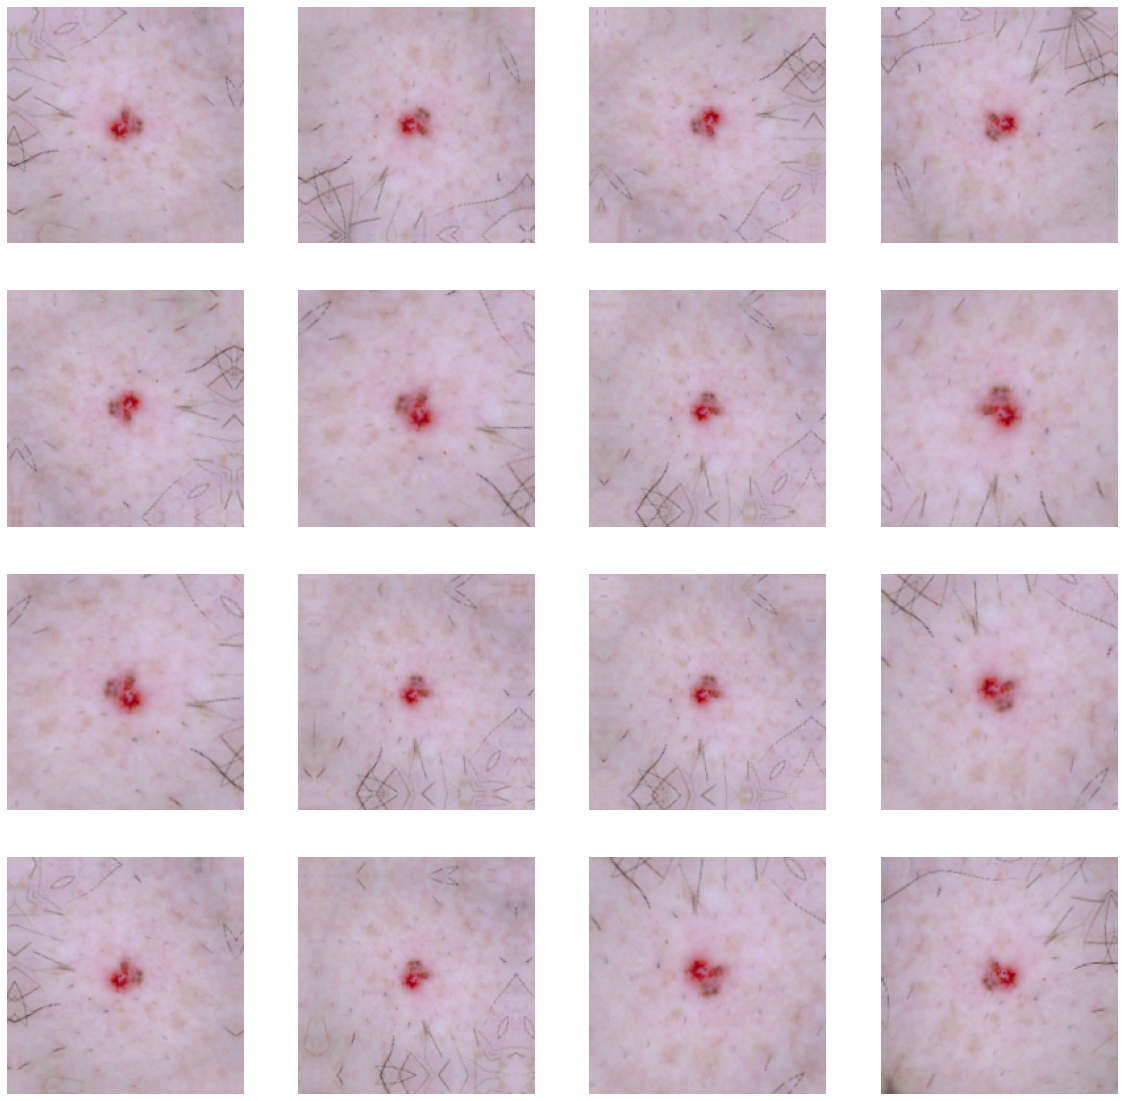

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

# Visualizing images passed through the augmentation strategy 

# Setting figure size
plt.figure(figsize=(20, 20))

# Loop through train dataset
for images, labels in train_ds.take(1):

    # Ramdomly pick one image and display 16 augmented images
    for idx in range(16):

        # Setting subplot coordinate
        ax = plt.subplot(4, 4, idx + 1)

        # Calling augmenter object to convert images
        augmented_image = ImageData_augmentation(images)

        # Display augmented images of randomly picked one image 
        plt.imshow(augmented_image[0])

        # Subpressing the axis of the plot
        plt.axis("off")


### Create CNN model 1 after Data augmentation


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

# Use Sequential from tensorflow.models library to build CNN model layer by layer
# Below model used following layers:
## First layer is built with the data augmentation layer
## Four convolution layers with filter size (3,3) and number of filters used 64 and 128 respectively and padding as "same" (i.e. after convolution the output layer size will be same as input layer)
## Two max pooling layer with filter size (2,2)
## One Flatten layer
## Three fully connected layer (including output softmax layer)
## FC layers used 512 no. of filters
## Convolution and Fully connected layers used activation function 'relu'

cnn_model = Sequential()

cnn_model.add(ImageData_augmentation)
cnn_model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cnn_model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (2,2)))

cnn_model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cnn_model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (2,2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dense(num_classes, activation='softmax'))

### Compiling the model 1 after Data augmentation

In [ ]:
## Your code goes here

# Compile the cnn model with 'Adam' optimizer and 'sparse_categorical_crossentropy' loass function
# Used 'Accuracy' as eveluation metric

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

- The CNN model uses **Adam** as optimizer and **sparse_categorical_crossentropy** as loss function
- We have used **Accuracy** metric for model evaluation

### Viewing summary of Model 1 after Data Augmentation

In [ ]:
# View the Summary of the model

cnn_model.summary()

Model: "sequential_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_126 (Sequential)  (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_408 (Conv2D)          (None, 180, 180, 64)      1792      
_________________________________________________________________
conv2d_409 (Conv2D)          (None, 178, 178, 64)      36928     
_________________________________________________________________
max_pooling2d_210 (MaxPoolin (None, 89, 89, 64)        0         
_________________________________________________________________
conv2d_410 (Conv2D)          (None, 89, 89, 128)       73856     
_________________________________________________________________
conv2d_411 (Conv2D)          (None, 87, 87, 128)       147584    
_________________________________________________________________
max_pooling2d_211 (MaxPoolin (None, 43, 43, 128)    

### Training the model 1

In [ ]:
## Your code goes here, note: train your model for 20 epochs

# Fiting the model

# Train the model with 20 epochs

epochs = 20
history = cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 10s 161ms/step - loss: 2.8842 - accuracy: 0.1992 - val_loss: 2.0369 - val_accuracy: 0.2327
Epoch 2/20
56/56 [==============================] - 9s 159ms/step - loss: 1.9892 - accuracy: 0.2405 - val_loss: 2.0738 - val_accuracy: 0.2573
Epoch 3/20
56/56 [==============================] - 9s 159ms/step - loss: 1.9261 - accuracy: 0.2620 - val_loss: 1.8017 - val_accuracy: 0.2975
Epoch 4/20
56/56 [==============================] - 9s 159ms/step - loss: 1.7300 - accuracy: 0.3468 - val_loss: 1.5662 - val_accuracy: 0.4116
Epoch 5/20
56/56 [==============================] - 9s 161ms/step - loss: 1.6554 - accuracy: 0.3888 - val_loss: 1.5466 - val_accuracy: 0.4586
Epoch 6/20
56/56 [==============================] - 9s 161ms/step - loss: 1.5458 - accuracy: 0.4464 - val_loss: 1.5684 - val_accuracy: 0.4318
Epoch 7/20
56/56 [==============================] - 9s 161ms/step - loss: 1.4886 - accuracy: 0.4778 - val_loss: 1.5326 - val_accuracy: 0.5078
Epoch

### Visualizing the training results of Modeel 1 after Data augmentation

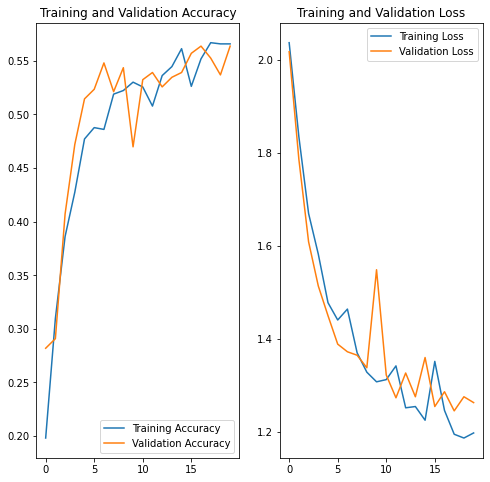

In [ ]:
# Visualizing the Training and Validation accuracy and loss against the epochs


# Getting the traning accuracy from history object created during model fitting
acc = history.history['accuracy']

# Getting the validation accuracy from history object created during model fitting
val_acc = history.history['val_accuracy']

# Getting the training loss from history object created during model fitting
loss = history.history['loss']

# Getting the validation loss from history object created during model fitting
val_loss = history.history['val_loss']

# Creating a list variable with number of epochs
epochs_range = range(epochs)

# Setting figute size for the plot
plt.figure(figsize=(8, 8))


# Setting subplot coordinate
plt.subplot(1, 2, 1)

# Plotting epoch vs. training accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')

# Plotting epoch vs. validation accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

# Setting display options
plt.legend(loc='lower right')

# Setting plot title
plt.title('Training and Validation Accuracy')


# Setting subplot coordinate
plt.subplot(1, 2, 2)

# Plotting epoch vs. training loss
plt.plot(epochs_range, loss, label='Training Loss')

# Plotting epoch vs. validation accuracy
plt.plot(epochs_range, val_loss, label='Validation Loss')

# Setting display options
plt.legend(loc='upper right')

# Setting plot title
plt.title('Training and Validation Loss')

# Showing the plot with show() method of matplotlib.pyplot 
plt.show()

### Inference:

- We can see from the aobve graphs , that the model is **`not overfitted`** ,with the train accuracy of `0.5610` (56.10%) and validation accuracy of `0.5459`(54.59%)


- But the model has low accuracy on both training and validation set.


- We can see from the aobve graphs , low loss optimization,with the train loss of `1.2592` and validation loss of `1.3579`. 


- `Loss is not reduced` so much.

## Model 2 with different Augmentation Strategy

- Rescaling to reduce data range from [0, 255] to [0, 1] and input shape used (180, 180, 3)
- RandomFlip with horizontal mode and seed as 123
- RandomRotation with factor 0.3 and seed value as 123
- RandomZoom with factor 0.2 and seed value as 123

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

# Applying following data augmentation strategy to reduce overfitting present in above model
## Rescaling to reduce data range from [0, 255] to [0, 1] and input shape used (180, 180, 3)
## RandomFlip with horizontal mode and seed as 123
## RandomRotation with factor 0.3 and seed value as 123
## RandomZoom with factor 0.2 and seed value as 123

ImageData_augmentation = Sequential()
ImageData_augmentation.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale = (1.0 / 255),input_shape = (img_height, img_width,3)))
ImageData_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal', seed=123))
ImageData_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.3, seed=123))
ImageData_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, seed=123))


### Visualizing the image after new augmentation strategy

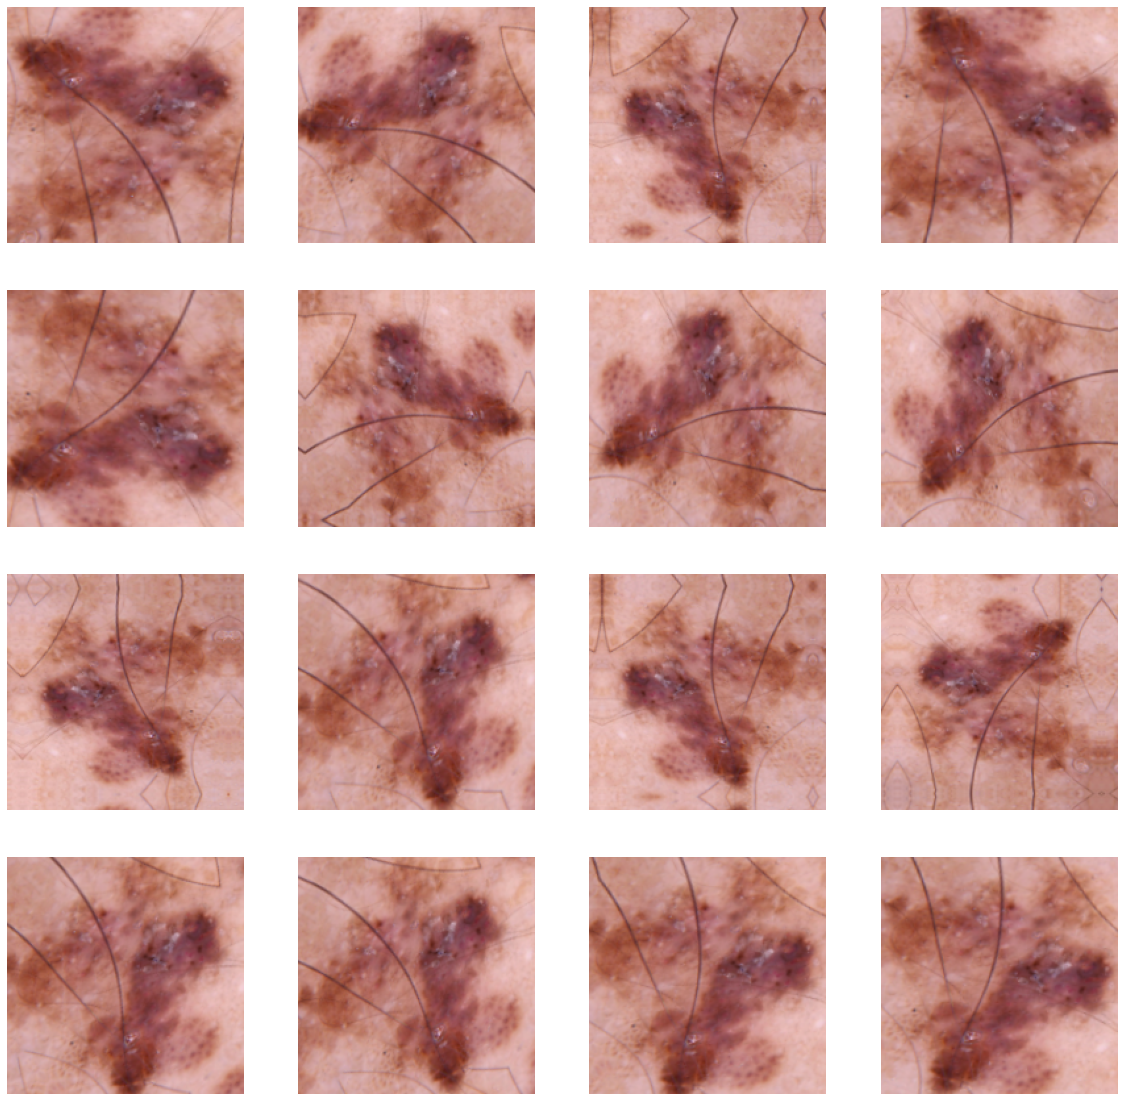

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

# Visualizing images passed through the augmentation strategy 

# Setting figure size
plt.figure(figsize=(20, 20))

# Loop through train dataset
for images, labels in train_ds.take(1):

    # Ramdomly pick one image and display 16 augmented images
    for idx in range(16):

        # Setting subplot coordinate
        ax = plt.subplot(4, 4, idx + 1)

        # Calling augmenter object to convert images
        augmented_image = ImageData_augmentation(images)

        # Display augmented images of randomly picked one image 
        plt.imshow(augmented_image[0])

        # Subpressing the axis of the plot
        plt.axis("off")


### Create the CNN model 2 after augmention


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

# Use Sequential from tensorflow.models library to build CNN model layer by layer
# Below model used following layers:
## First layer is built with the data augmentation layer
## Six convolution layers with filter size (1,1), (2,2) and number of filters used 16, 32 and 64 respectively and padding as "same" (i.e. after convolution the output layer size will be same as input layer)
## Two max pooling layer with filter size (2,2)
## One Flatten layer
## Three fully connected layer (including output softmax layer)
## Two FC layers used 512 and 1024 no. of filters respectively
## Convolution and Fully connected layers used activation function 'relu'

cnn_model = Sequential()
cnn_model.add(ImageData_augmentation)
cnn_model.add(Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu'))
cnn_model.add(Conv2D(16, kernel_size = (1,1), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (2,2)))

cnn_model.add(Conv2D(32, kernel_size = (2,2), padding = 'same', activation = 'relu'))
cnn_model.add(Conv2D(32, kernel_size = (2,2), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (2,2)))

cnn_model.add(Conv2D(64, kernel_size = (2,2), padding = 'same', activation = 'relu'))
cnn_model.add(Conv2D(64, kernel_size = (2,2), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (2,2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dense(1024, activation='relu'))
cnn_model.add(Dense(num_classes, activation='softmax'))

### Compiling CNN model 2

In [ ]:
## Your code goes here

# Compile the cnn model with 'Adam' optimizer and 'sparse_categorical_crossentropy' loass function
# Used 'Accuracy' as eveluation metric

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

- This CNN model uses **Adam** as optimizer and **sparse_categorical_crossentropy** as loss function
- We have used **Accuracy** metric for model evaluation

### Viewing the summary of Model 2

In [ ]:
# View Summary of the model

cnn_model.summary()

Model: "sequential_132"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_130 (Sequential)  (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_424 (Conv2D)          (None, 180, 180, 16)      64        
_________________________________________________________________
conv2d_425 (Conv2D)          (None, 180, 180, 16)      272       
_________________________________________________________________
max_pooling2d_218 (MaxPoolin (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_426 (Conv2D)          (None, 90, 90, 32)        2080      
_________________________________________________________________
conv2d_427 (Conv2D)          (None, 89, 89, 32)        4128      
_________________________________________________________________
max_pooling2d_219 (MaxPoolin (None, 44, 44, 32)     

### Training the CNN model 2

In [ ]:
## Your code goes here, note: train your model for 20 epochs

# Fiting the model

# Train the model with 20 epochs

epochs = 20
history = cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 43ms/step - loss: 2.0755 - accuracy: 0.1597 - val_loss: 2.0179 - val_accuracy: 0.2819
Epoch 2/20
56/56 [==============================] - 2s 40ms/step - loss: 1.8932 - accuracy: 0.2872 - val_loss: 1.7862 - val_accuracy: 0.2908
Epoch 3/20
56/56 [==============================] - 2s 40ms/step - loss: 1.6941 - accuracy: 0.3593 - val_loss: 1.6087 - val_accuracy: 0.4072
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5912 - accuracy: 0.4285 - val_loss: 1.5136 - val_accuracy: 0.4720
Epoch 5/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4951 - accuracy: 0.4757 - val_loss: 1.4495 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4818 - accuracy: 0.4686 - val_loss: 1.3883 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4844 - accuracy: 0.4630 - val_loss: 1.3719 - val_accuracy: 0.5481
Epoch 8/20
56

### Visualizing training results of CNN model 2

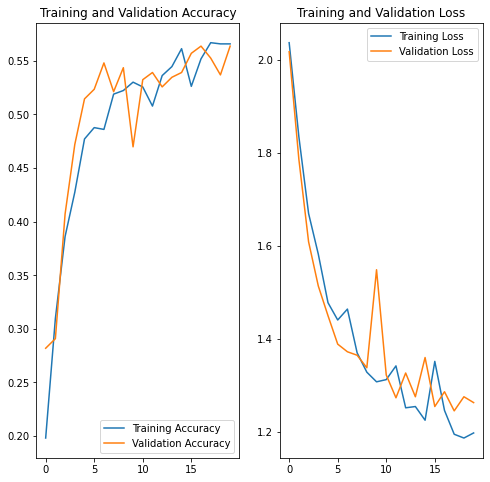

In [ ]:
# Visualizing the Training and Validation accuracy and loss against the epochs


# Getting the traning accuracy from history object created during model fitting
acc = history.history['accuracy']

# Getting the validation accuracy from history object created during model fitting
val_acc = history.history['val_accuracy']

# Getting the training loss from history object created during model fitting
loss = history.history['loss']

# Getting the validation loss from history object created during model fitting
val_loss = history.history['val_loss']

# Creating a list variable with number of epochs
epochs_range = range(epochs)

# Setting figute size for the plot
plt.figure(figsize=(8, 8))


# Setting subplot coordinate
plt.subplot(1, 2, 1)

# Plotting epoch vs. training accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')

# Plotting epoch vs. validation accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

# Setting display options
plt.legend(loc='lower right')

# Setting plot title
plt.title('Training and Validation Accuracy')


# Setting subplot coordinate
plt.subplot(1, 2, 2)

# Plotting epoch vs. training loss
plt.plot(epochs_range, loss, label='Training Loss')

# Plotting epoch vs. validation accuracy
plt.plot(epochs_range, val_loss, label='Validation Loss')

# Setting display options
plt.legend(loc='upper right')

# Setting plot title
plt.title('Training and Validation Loss')

# Showing the plot with show() method of matplotlib.pyplot 
plt.show()

### Inference:

- After changing the filter size and adding two more convolution layer as well, we can see from the aobve graphs , that the model is **`not overfitted`** ,with the train accuracy of `0.5697` (56.97%) and validation accuracy of `0.5638`(56.38%)


- But the model has low accuracy on both training and validation set.


- We can see from the aobve graphs , low loss optimization,with the train loss of `1.1799` and validation loss of `1.2624`.


- `Loss is not reduced` so much.

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### Overall observation after training performed using data augmentation




- We can see that the model **`has not been overfitted`** anymore after applying augmentation strategy, but still it has `low accuracy` and we can tell it is somewhat **`Underfitted`** with grater loss.


- Hence, using `data augmentation strategy` we got evidence of improvement in terms of reduced `Overfitment`.



**`CNN Model 1 with data augemntation`**:


- We can see from the aobve graphs , that the model is **`not overfitted`** ,with the train accuracy of `0.5610` (56.10%) and validation accuracy of `0.5459`(54.59%)


- But the model has low accuracy on both training and validation set.


- We can see from the aobve graphs , low loss optimization,with the train loss of `1.2592` and validation loss of `1.3579`. 


- `Loss is not reduced` so much.



**`CNN Model 2 with data augemntation`**:


- After changing the filter size and adding two more convolution layer as well, we can see from the aobve graphs , that the model is **`not overfitted`** ,with the train accuracy of `0.5697` (56.97%) and validation accuracy of `0.5638`(56.38%)


- But the model has low accuracy on both training and validation set.


- We can see from the aobve graphs , low loss optimization,with the train loss of `1.1799` and validation loss of `1.2624`.


- `Loss is not reduced` so much.

## Visualize Class distribution on Training Dataset

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

____________________________________________________________________

Class Name: actinic keratosis,  Image Count: 114 (5.092%)

Class Name: basal cell carcinoma,  Image Count: 376 (16.793%)

Class Name: dermatofibroma,  Image Count: 95 (4.243%)

Class Name: melanoma,  Image Count: 438 (19.562%)

Class Name: nevus,  Image Count: 357 (15.945%)

Class Name: pigmented benign keratosis,  Image Count: 462 (20.634%)

Class Name: seborrheic keratosis,  Image Count: 77 (3.439%)

Class Name: squamous cell carcinoma,  Image Count: 181 (8.084%)

Class Name: vascular lesion,  Image Count: 139 (6.208%)
___________________________________________________________________




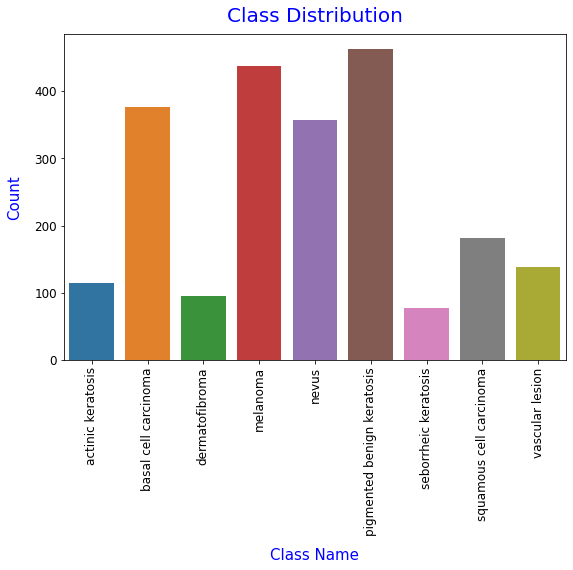

In [15]:
## Your code goes here.

# Visualizing Class Imbalance

print("____________________________________________________________________")

# Initializing a dict variable
imgCls_count = {}

# Loop through each class
for class_name in class_names:
    
    # Creating directory path concatenating train folder path and class names
    path = os.path.join(data_dir_train, class_name)
    
    # Creating path object with the class folder paths
    train_dir = pathlib.Path(path)
    
    # Storing class name and image count in each class in the dict variable
    imgCls_count[class_name] = len(list(train_dir.glob('*.jpg')))
    
    # Calculating %Percentage imbalance
    dist_percent = round((imgCls_count[class_name]/image_count_train)*100,3)
    
    # Printing the Results
    print("")
    print("Class Name: {0},  Image Count: {1} ({2}%)".format(class_name,imgCls_count[class_name],dist_percent))
    
     
print("___________________________________________________________________")
print("")
print("")

# Setting the figure size
plt.figure(figsize=(9,6))

# Plotting bar graph to display Class distribution
sns.barplot(list(imgCls_count.keys()), list(imgCls_count.values())) 

# Setting x-label and y-label
plt.xlabel('Class Name', fontsize = 15, color = 'blue', labelpad = 12) 
plt.ylabel('Count', fontsize = 15, color = 'blue', labelpad = 12) 

# Setting x-ticks and y-ticks
plt.xticks(fontsize = 12, rotation = 90)
plt.yticks(fontsize = 12)

# Setting title of the plot
plt.title("Class Distribution", fontsize = 20, color = 'blue', pad = 12)

# Showing the plot with show() method of matplotlib.pyplot 
plt.show()     


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?

- `Seborrheic Keratosis` has the least number of sample `Image Count : 77 (3.439%)`.




#### - Which classes dominate the data in terms proportionate number of samples?

- `Pigmented Benign Keratosis ` dominate the data in terms proportionate number of samples with `Image Count : 462 (20.634%)`


- **Overall Class Distribution**

    - Class Name : Actinic Keratosis,  Image Count : 114 (5.092%)
    - Class Name : Basal Cell Carcinoma,  Image Count : 376 (16.793%)
    - Class Name : Dermatofibroma,  Image Count : 95 (4.243%)
    - Class Name : Melanoma,  Image Count : 438 (19.562%)
    - Class Name : Nevus,  Image Count : 357 (15.945%)
    - Class Name : Pigmented Benign Keratosis,  Image Count : 462 (20.634%)
    - Class Name : Seborrheic Keratosis,  Image Count : 77 (3.439%)
    - Class Name : Squamous Cell Carcinoma,  Image Count : 181 (8.084%)
    - Class Name : Vascular Lesion,  Image Count : 139 (6.208%)
 

## Rectification of class imbalance using ' Augmentor' class

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [13]:
# Install Augmentor package

!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [16]:
# Creating 500 samples for each class using Augmentor package


# Setting Train folder path
path_to_training_dataset="/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

# Importing Augmentor library
import Augmentor

# Loop through each class
for i in class_names:

    # Path where the samples will be created
    print(path_to_training_dataset + i)

    # Pipeline the Path object where the operation would be performed
    p = Augmentor.Pipeline(path_to_training_dataset + i)

    # Defining the operation used by the augmentor
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

    # Defining the sample size 
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF55D07CB90>: 100%|██████████| 500/500 [00:19<00:00, 26.10 Samples/s]


/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF56E28FE50>: 100%|██████████| 500/500 [00:18<00:00, 26.36 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF55D0A2E10>: 100%|██████████| 500/500 [00:19<00:00, 25.01 Samples/s]


/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF55D0A2CD0>: 100%|██████████| 500/500 [01:29<00:00,  5.59 Samples/s]


/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF55D0E3FD0>: 100%|██████████| 500/500 [01:13<00:00,  6.81 Samples/s]


/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF55D06FF90>: 100%|██████████| 500/500 [00:19<00:00, 25.58 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF55D156990>: 100%|██████████| 500/500 [00:43<00:00, 11.42 Samples/s]


/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF55D39F110>: 100%|██████████| 500/500 [00:19<00:00, 25.34 Samples/s]


/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF5577C7990>: 100%|██████████| 500/500 [00:19<00:00, 25.55 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

- Created **500 samples** of each class in Training Dataset using Augmentor class

## Class distribution check after adding new 500 sample per calss

#### Count of total added samples including all classes

In [18]:
# Displaying the total image count including all classes generated by augmentor
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [19]:
# Creating list of image path for each images in the Training folder

path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0032270.jpg',
 '/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0027903.jpg',
 '/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0027888.jpg',
 '/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0027563.jpg',
 '/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0027269.jpg',
 '/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0030956.jpg',
 '/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0032538.jpg',
 '/con

In [20]:
# Creating list with length as the number of images present in original dataset with class name

lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [21]:
# Creating a dictionary object with image name along with path as key and class label as values (Excluding augmented samples)

dataframe_dict = dict(zip(path_list, lesion_list))

In [22]:
# Creating DataFrame with the dict object created above

original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [ ]:
# Displaying top 5 rows from original dataframe

original_df.head()

Path            Label
0  /content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0032270.jpg  vascular lesion
1  /content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0027903.jpg  vascular lesion
2  /content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0027888.jpg  vascular lesion
3  /content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0027563.jpg  vascular lesion
4  /content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ISIC_0027269.jpg  vascular lesion

In [23]:
# Creating a list object with path of newly created samples

path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033450.jpg_bd916fa6-69f7-4206-a81b-18b5a997141f.jpg',
 '/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026456.jpg_0d444117-f52a-4c21-8516-b4ae9074147d.jpg',
 '/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025707.jpg_b98eac12-697d-4384-af94-bd833f95a800.jpg',
 '/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028188.jpg_8fefe12a-3dda-47da-af91-e3150ad3c8c4.jpg',
 '/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular l

In [24]:
# Creating list to display class names, with length as number of total generated samples

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [25]:
# Creating a dictionary object with image name along with path as key and class label as values

dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [26]:
# Creating final DataFrame object containing all image path (Original image along with augmentor generated image)

# DataFrame containing new samples only
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

# Creating final dataframe
new_df = original_df.append(df2)

In [27]:
# Viewing value counts for each class after combining original and augmented samples

new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

### Inference:

- Above are the class distribution of the images per class `after creation of 500 sample per class`.

### Visualizing Class distribution after creation of 500 samples per class

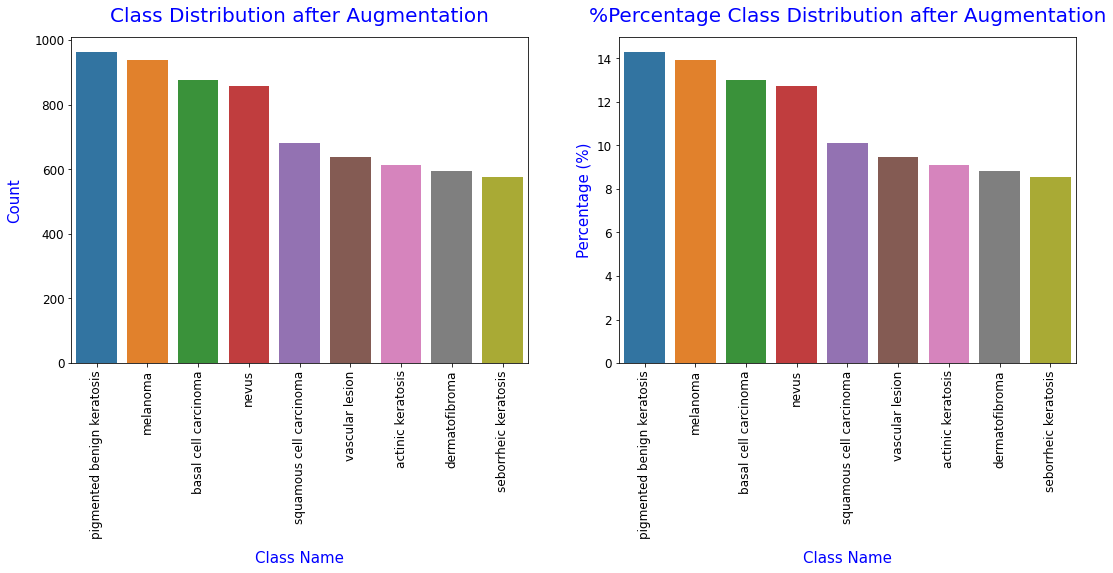

In [28]:
# Visualizing Class Distributionafter Augmentation

# Setting figure size
plt.figure(figsize=(18,6))

# Setting coordinate for subplots
plt.subplot(1,2,1)

# Plotting bar graph for displaying class distribution
sns.barplot(list(new_df['Label'].value_counts().index), list(new_df['Label'].value_counts().values)) 

# Setting x-axis & y-axis labels and display settings
plt.xlabel('Class Name', fontsize = 15, color = 'blue', labelpad = 12) 
plt.ylabel('Count', fontsize = 15, color = 'blue', labelpad = 12) 

# Setting x-ticks & y-ticks labels and display settings
plt.xticks(fontsize = 12, rotation = 90)
plt.yticks(fontsize = 12)

# Setting title for the distribution plot
plt.title("Class Distribution after Augmentation", fontsize = 20, color = 'blue', pad = 15)

# Setting coordinate for subplots
plt.subplot(1,2,2)

# Plotting bar graph for displaying %Percentage class distribution
sns.barplot(list(new_df['Label'].value_counts(normalize=True).index), list((new_df['Label'].value_counts(normalize=True).values*100)))

# Setting x-axis & y-axis labels and display settings
plt.xlabel('Class Name', fontsize = 15, color = 'blue', labelpad = 12) 
plt.ylabel('Percentage (%)', fontsize = 15, color = 'blue', labelpad = 5) 

# Setting x-ticks & y-ticks labels and display settings
plt.xticks(fontsize = 12, rotation = 90)
plt.yticks(fontsize = 12)

# Setting title of the plot
plt.title("%Percentage Class Distribution after Augmentation", fontsize = 20, color = 'blue', pad = 15)

# Showing the plot with show() method of matplotlib.pyplot 
plt.show()  

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.


### Inference:

- We have plotted the count plot and %Percentahe plot of the 9 classes after adding the 500 sample per class.



- From these class distribution we can say that,
    - ` pigmented benign keratosis ` has the higest dominance 
    - `seborrheic keratosis` has the lowest dominance

#### **Todo**: Train the model on the data created using Augmentor

### Defining model training parameters

In [29]:
# Setting batch size, image height and image width for model training

batch_size = 32
img_height = 180
img_width = 180

### Create a training dataset

In [30]:
# Creating Training Dataset using tf.keras.preprocessing.image_dataset_from_directory method with 80% images from Train Folder using seed=123, img_height=180, img_width=180 and batch_size=32

# Setting path for train data directory
data_dir_train="/content/gdrive/MyDrive/CNN_Projects/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Create a validation dataset

In [31]:
# Creating Validation Dataset using tf.keras.preprocessing.image_dataset_from_directory method with 20% images from Train Folder using seed=123, img_height=180, img_width=180 and batch_size=32

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [32]:
# Displaying number of distinct classes of skin cancer along with the name of each class

# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)
print("")

num_classes = len(class_names)
print("Number of Classes in Dataset:", num_classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

Number of Classes in Dataset: 9


### Inference:

- There are total `9 classes of skin cancer`


- Classes are `'actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'`

#### **Todo:** Create your model (make sure to include normalization)

#### **Todo:**  Visualize the model results

## CNN model 1 after recitification of class imbalance

### Create CNN Model 1

In [42]:
## your code goes here

# Use Sequential from tensorflow.models library to build CNN model layer by layer
# Below model used following layers:
## First layer is used to rescalling the input of nural network from range [0, 255] to [0, 1]
## Four convolution layers with filter size (3,3) and number of filters used 32 and 64 and padding as "same" (i.e. after convolution the output layer size will be same as input layer)
## Two max pooling layer with filter size (2,2)
## One Flatten layer
## One fully connected layer (including output softmax layer) with 512 number of filters
## Convolution and Fully connected layers used activation function 'relu'
## Used Dropout(0.25) after two convotution layer and FC layer
## Used BatchNormalization in each convolution layer

cnn_model = Sequential()
cnn_model.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale = (1.0 / 255), input_shape=(img_height, img_width,3)))
cnn_model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size = (2,2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size = (2,2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(num_classes, activation='softmax'))

### Compile CNN Model 1

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [43]:
## your code goes here

# Compile the cnn model with 'Adam' optimizer with learning rate 0.001 and 'sparse_categorical_crossentropy' loass function
# Used 'Accuracy' as eveluation metric

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

- CNN model uses **Adam** as optimizer with learning rate 0.001 and **sparse_categorical_crossentropy** as loss function
- We have used **Accuracy** metric for model evaluation

### Viewing Summary of Model 1

In [44]:
# Viewing summary of the model

cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 180, 180, 32)      128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 178, 178, 32)      9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 178, 178, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 89, 89, 32)       

### Train CNN model 1

In [45]:
# Fiting the model

# Train the model with 30 epochs

epochs = 30


history = cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 52s 294ms/step - loss: 29.9262 - accuracy: 0.2478 - val_loss: 57.3585 - val_accuracy: 0.0898
Epoch 2/30
169/169 [==============================] - 52s 298ms/step - loss: 2.0342 - accuracy: 0.2405 - val_loss: 35.5516 - val_accuracy: 0.1440
Epoch 3/30
169/169 [==============================] - 51s 294ms/step - loss: 1.9018 - accuracy: 0.2842 - val_loss: 11.9865 - val_accuracy: 0.2309
Epoch 4/30
169/169 [==============================] - 51s 296ms/step - loss: 1.8006 - accuracy: 0.3143 - val_loss: 6.2474 - val_accuracy: 0.3586
Epoch 5/30
169/169 [==============================] - 51s 295ms/step - loss: 1.7562 - accuracy: 0.3370 - val_loss: 5.4212 - val_accuracy: 0.3215
Epoch 6/30
169/169 [==============================] - 51s 296ms/step - loss: 1.6925 - accuracy: 0.3678 - val_loss: 1.7161 - val_accuracy: 0.3756
Epoch 7/30
169/169 [==============================] - 50s 292ms/step - loss: 1.6041 - accuracy: 0.3763 - val_loss: 2.5830 - va

### Visualize the model results after Training Model 1

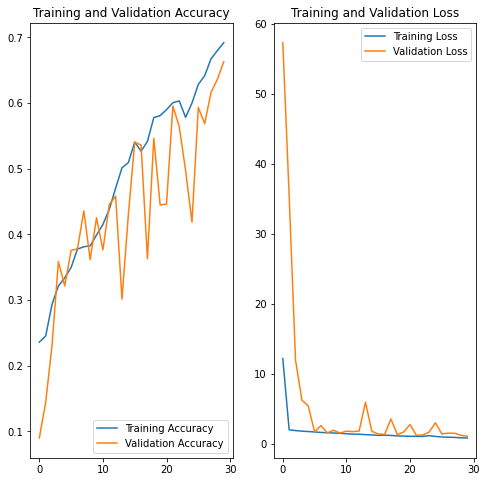

In [46]:
# Visualizing the Training and Validation accuracy and loss against the epochs


# Getting the traning accuracy from history object created during model fitting
acc = history.history['accuracy']

# Getting the validation accuracy from history object created during model fitting
val_acc = history.history['val_accuracy']

# Getting the training loss from history object created during model fitting
loss = history.history['loss']

# Getting the validation loss from history object created during model fitting
val_loss = history.history['val_loss']

# Creating a list variable with number of epochs
epochs_range = range(epochs)

# Setting figute size for the plot
plt.figure(figsize=(8, 8))


# Setting subplot coordinate
plt.subplot(1, 2, 1)

# Plotting epoch vs. training accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')

# Plotting epoch vs. validation accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

# Setting display options
plt.legend(loc='lower right')

# Setting plot title
plt.title('Training and Validation Accuracy')


# Setting subplot coordinate
plt.subplot(1, 2, 2)

# Plotting epoch vs. training loss
plt.plot(epochs_range, loss, label='Training Loss')

# Plotting epoch vs. validation accuracy
plt.plot(epochs_range, val_loss, label='Validation Loss')

# Setting display options
plt.legend(loc='upper right')

# Setting plot title
plt.title('Training and Validation Loss')

# Showing the plot with show() method of matplotlib.pyplot 
plt.show()

### Inference:


- we have used dropouts with batch normalization , We can see from the aobve graphs , that the model is **`not overfitted`** ,with the train accuracy of `0.6973` (69.73%) and validation accuracy of `0.6630`(66.30%)


- But the model has `increased in accuracy` on both training and validation set.


- We can see from the aobve graphs , good loss optimization,with the train loss of `0.8010` and validation loss of `1.06`. 


- Overall `Loss is reduced`.


### CNN model 2 after rectifying class imbalance

In [88]:
## your code goes here

# Use Sequential from tensorflow.models library to build CNN model layer by layer
# Below model used following layers:
## First layer is used to rescalling the input of nural network from range [0, 255] to [0, 1]
## One convolution layers with filter size (1,1) and number of filters used 16 and padding as "same" (i.e. after convolution the output layer size will be same as input layer)
## Five convolution layers with filter size (2,2) and number of filters used 16, 32 & 64 and padding as "same" (i.e. after convolution the output layer size will be same as input layer)
## Three max pooling layer with filter size (2,2)
## One Flatten layer
## One fully connected layer with 512 number of filters
## Output softmax layer
## Convolution and Fully connected layers used activation function 'relu'
## Used Dropout(0.29) after each convotution layer and Dropout(0.27) in FC layer
## Used BatchNormalization in each convolution layer

cnn_model = Sequential()
cnn_model.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale = (1.0 / 255), input_shape=(img_height, img_width,3)))
cnn_model.add(Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(16, kernel_size = (2,2), activation = 'relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size = (2,2)))
cnn_model.add(Dropout(0.29))

cnn_model.add(Conv2D(32, kernel_size = (2,2), padding = 'same', activation = 'relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(32, kernel_size = (2,2), activation = 'relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size = (2,2)))
cnn_model.add(Dropout(0.29))

cnn_model.add(Conv2D(64, kernel_size = (2,2), padding = 'same', activation = 'relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(64, kernel_size = (2,2), activation = 'relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size = (2,2)))
cnn_model.add(Dropout(0.29))

cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.27))
cnn_model.add(Dense(num_classes, activation='softmax'))

### Compile the CNN model 2

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [89]:
## your code goes here

# Compile the cnn model with 'Adam' optimizer with learning rate 0.001 and 'sparse_categorical_crossentropy' loass function
# Used 'Accuracy' as eveluation metric

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

- These CNN model uses **Adam** as optimizer with learning rate 0.001 and **sparse_categorical_crossentropy** as loss function
- We have used **Accuracy** metric for model evaluation

### Viewing summary of Model 2

In [90]:
# Viewing summary of model

cnn_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_14 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 180, 180, 16)      64        
_________________________________________________________________
batch_normalization_65 (Batc (None, 180, 180, 16)      64        
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 179, 179, 16)      1040      
_________________________________________________________________
batch_normalization_66 (Batc (None, 179, 179, 16)      64        
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 89, 89, 16)        0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 89, 89, 16)      

### Train CNN model 2 with 30 epochs

In [91]:
# Fiting the model

# Train the model with 30 epochs

epochs = 30

history = cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 48s 273ms/step - loss: 13.6536 - accuracy: 0.2875 - val_loss: 34.4416 - val_accuracy: 0.1403
Epoch 2/30
169/169 [==============================] - 47s 270ms/step - loss: 1.5688 - accuracy: 0.4218 - val_loss: 31.8212 - val_accuracy: 0.1433
Epoch 3/30
169/169 [==============================] - 47s 270ms/step - loss: 1.3777 - accuracy: 0.4849 - val_loss: 11.4944 - val_accuracy: 0.1841
Epoch 4/30
169/169 [==============================] - 47s 271ms/step - loss: 1.2701 - accuracy: 0.5219 - val_loss: 4.6186 - val_accuracy: 0.3281
Epoch 5/30
169/169 [==============================] - 47s 270ms/step - loss: 1.1895 - accuracy: 0.5389 - val_loss: 2.6067 - val_accuracy: 0.4751
Epoch 6/30
169/169 [==============================] - 47s 269ms/step - loss: 1.0750 - accuracy: 0.5920 - val_loss: 1.8548 - val_accuracy: 0.5293
Epoch 7/30
169/169 [==============================] - 47s 273ms/step - loss: 0.9904 - accuracy: 0.6044 - val_loss: 2.1155 - va

### Visualize the model results of CNN Model 2

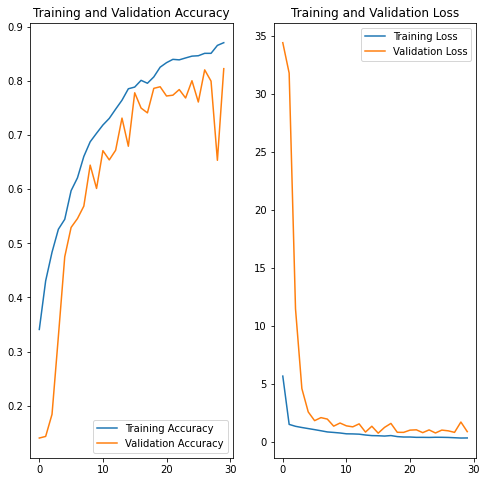

In [92]:
# Visualizing the Training and Validation accuracy and loss against the epochs


# Getting the traning accuracy from history object created during model fitting
acc = history.history['accuracy']

# Getting the validation accuracy from history object created during model fitting
val_acc = history.history['val_accuracy']

# Getting the training loss from history object created during model fitting
loss = history.history['loss']

# Getting the validation loss from history object created during model fitting
val_loss = history.history['val_loss']

# Creating a list variable with number of epochs
epochs_range = range(epochs)

# Setting figute size for the plot
plt.figure(figsize=(8, 8))


# Setting subplot coordinate
plt.subplot(1, 2, 1)

# Plotting epoch vs. training accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')

# Plotting epoch vs. validation accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

# Setting display options
plt.legend(loc='lower right')

# Setting plot title
plt.title('Training and Validation Accuracy')


# Setting subplot coordinate
plt.subplot(1, 2, 2)

# Plotting epoch vs. training loss
plt.plot(epochs_range, loss, label='Training Loss')

# Plotting epoch vs. validation accuracy
plt.plot(epochs_range, val_loss, label='Validation Loss')

# Setting display options
plt.legend(loc='upper right')

# Setting plot title
plt.title('Training and Validation Loss')

# Showing the plot with show() method of matplotlib.pyplot 
plt.show()

### Inference:


- After increase in a convolution layers and changing dropouts rate with batch normalization , We can see from the aobve graphs , that the model is **`not at all Overfitted`** ,with the train accuracy of `0.8646` (86.46%) and validation accuracy of `0.8226`(82.26%)


- Also the model has `increased in accuracy` on both training and validation set.


- We can see from the aobve graphs , good loss optimization,with the train loss of `0.3633` and validation loss of `0.9070`. 


- Hence, Overall `Loss is reduced`.


- After rectifying class imbalance by increasing the sample size in each class , we have seen `significant improve in model accuracy` and `get rid of model Overfitment`.

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### Overall observation  after rectifying class imbalance


- After class rebalance , we have seen `significant improve in model accuracy` and `get rid of Overfitment`.Class rebalance actually helps in it.


**` CNN model 1 after class rebalance`** 


- we have used dropouts with batch normalization , We can see from the aobve graphs , that the model is **`not overfitted`** ,with the train accuracy of `0.6973` (69.73%) and validation accuracy of `0.6630`(66.30%)


- But the model has `increased in accuracy` on both training and validation set.


- We can see from the aobve graphs , good loss optimization,with the train loss of `0.8010` and validation loss of `1.06`. 


- Overall `Loss is reduced`.


**` CNN model 2 after class rebalance`** 


- After increase in a convolution layers and changing dropouts rate with batch normalization , We can see from the aobve graphs , that the model is **`not at all Overfitted`** ,with the train accuracy of `0.8646` (86.46%) and validation accuracy of `0.8226`(82.26%)


- Also the model has `increased in accuracy` on both training and validation set.


- We can see from the aobve graphs , good loss optimization,with the train loss of `0.3633` and validation loss of `0.9070`. 


- Hence, Overall `Loss is reduced`.

### END